In [1]:
from google_play_scraper import reviews, Sort
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
APP_ID = "br.com.intermedium"
LANGUAGE = "pt-br"
COUNTRY = "br"

TOTAL_ROWS_OF_DATA = 10000

In [5]:
results, _ = reviews(
    APP_ID,
    lang=LANGUAGE,
    country=COUNTRY,
    sort=Sort.NEWEST,
    count=TOTAL_ROWS_OF_DATA,
    filter_score_with=None,
)

In [6]:
data = []

for result in results:
    review_id = result["reviewId"]
    content = result["content"]
    score = result["score"]
    thumbs_up_count = result["thumbsUpCount"]
    review_created_version = result["reviewCreatedVersion"]
    at = result["at"]
    reply_content = result["replyContent"]
    replied_at = result["repliedAt"]
    app_version = result["appVersion"]

    data.append(
        {
            "Review ID": review_id,
            "Content": content,
            "Score": score,
            "Thumbs Up Count": thumbs_up_count,
            "Review Created Version": review_created_version,
            "At": at,
            "Reply Content": reply_content,
            "Replied At": replied_at,
            "App Version": app_version,
        }
    )

df = pd.DataFrame(data)

In [7]:
df.head()

,Review ID,Content,Score,Thumbs Up Count,Review Created Version,At,Reply Content,Replied At,App Version
0,8780333e-c649-47ce-a13f-44174b76886f,Nao estou conseguindo acessar minha conta. Ped...,3,0,11.3.6,2023-05-28 12:33:40,None,NaT,11.3.6
1,0fe23ba9-1069-4a26-b521-2435d03d95c6,"O app é bom,porém o código de verificação não ...",1,0,11.5.3,2023-05-28 12:27:29,None,NaT,11.5.3
2,27e8e629-5122-4ed6-906c-129a266d27ea,muito bom fasso tudo pelo app,5,0,11.5.3,2023-05-28 12:24:41,"Oi, tudo bem? Obrigado pelo seu feedback, fica...",2023-05-28 12:47:51,11.5.3
3,82a9fd15-ca61-484a-8ce3-2b2d5a536e82,"O banco é bom, mas direto ele coloca meu limit...",1,0,11.4.6,2023-05-28 12:17:01,"Oi! Para que possamos te ajudar, entre em cont...",2023-05-28 12:47:56,11.4.6
4,04151fcd-d250-40dc-b19b-5388fc36d834,Ótimo,5,0,11.5.3,2023-05-28 12:15:02,Oi! Agradecemos o seu feedback! Estamos sempre...,2023-05-28 12:18:11,11.5.3


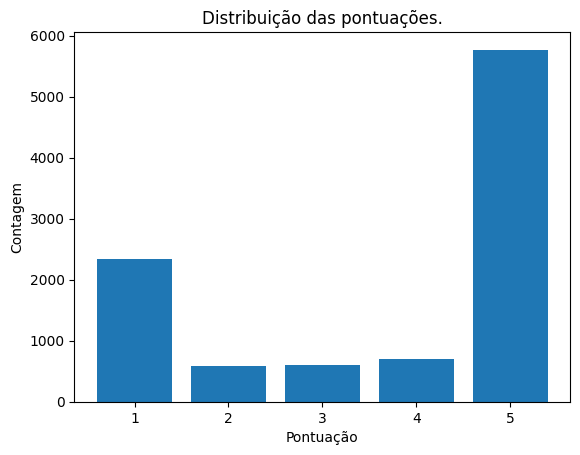

In [8]:
score_counts = df['Score'].value_counts()
score_counts = score_counts.sort_index()

plt.bar(score_counts.index, score_counts.values)

plt.title('Distribuição das pontuações.')
plt.xlabel('Pontuação')
plt.ylabel('Contagem')

plt.show()

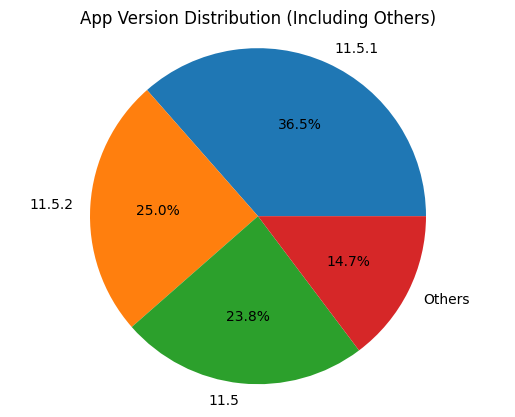

In [10]:
version_counts = df['App Version'].value_counts(dropna=True)

version_percentages = version_counts / len(df) * 100

threshold = 10
other_versions = version_percentages[version_percentages <= threshold]
other_percentage = other_versions.sum()

version_percentages = version_percentages[version_percentages > threshold]
version_percentages['Others'] = other_percentage

plt.pie(version_percentages, labels=version_percentages.index, autopct='%1.1f%%')
plt.title("App Version Distribution (Including Others)")
plt.axis('equal')
plt.show()


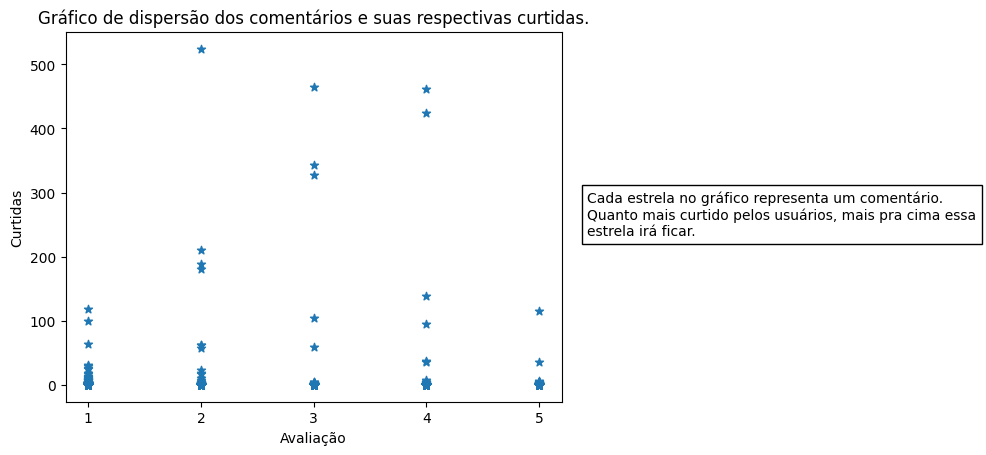

In [11]:
x = df['Score']
y = df['Thumbs Up Count']

plt.scatter(x, y, marker='*')
plt.xlabel('Avaliação')
plt.ylabel('Curtidas')
plt.title('Gráfico de dispersão dos comentários e suas respectivas curtidas.')

plt.xticks(range(int(min(x)), int(max(x)) + 1))

texto = 'Cada estrela no gráfico representa um comentário.\nQuanto mais curtido pelos usuários, mais pra cima essa\nestrela irá ficar.'
plt.text(0.94, 0.5, texto, bbox=dict(facecolor='white', edgecolor='black'), transform=plt.gcf().transFigure, fontsize=10, va='center', ha='left')

plt.show()